In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import copy
import csv
import tqdm
%matplotlib inline

# Import regions
Import a GeoJSON file of Manhattan divided into cells.  
Each cell has a unique identifier **cell_id** and a set of coordinates which identify the cell in the cell grid.  
A cell has a shape defined using a POLYGON.

In [2]:
gdf = gpd.read_file("./data/grid_Manhattan_50.geojson")
gdf.crs = {'init' :'epsg:2236', 'units':'m'}
gdf = gdf.to_crs({'init':'epsg:4326'})
tmp = ['cell_id'] + list(gdf.columns[1:])
gdf.columns = tmp
gdf['cell_id'] = gdf['cell_id'].map(int)
gdf.head()

,cell_id,id_x,id_y,areas,geometry
0,0,0,11,Manhattan,POLYGON ((-74.04715487327691 40.68978359041678...
1,1,0,12,Manhattan,POLYGON ((-74.04715480344612 40.68978362585598...
2,2,0,13,Manhattan,POLYGON ((-74.04709962451703 40.69031188048342...
3,3,0,14,Manhattan,"POLYGON ((-74.0471302635036 40.69068167992769,..."
4,4,1,11,Manhattan,POLYGON ((-74.04657387930314 40.68968809102005...


# Understand the data
## Import POIs
A POI - Point of Interests has the following information: 

```
['name', 'address', 'crossStreet', 'categories', 'checkin', 'usercount', 'boros', 'latitude', 'longitude', 'geometry', 'cellID']
```

'../../data/w2v_urban/Foursquare/Manhattan/foursquare_Manhattan_50.csv' contains all the pois of both training and tests cells.

In [3]:
pois_list_path = '../../data/w2v_urban/Foursquare/Manhattan/foursquare_Manhattan_50.csv'

pois = []
with open(pois_list_path,  encoding="utf8") as csvfile:
    pois_reader = csv.reader(csvfile, delimiter=',')
    # do not read the first element of each row
    # unamed ?
    for i, row in enumerate(pois_reader):
        if i == 0:
            labels = row[1:]
        else:
            pois.append(row[1:])

print(labels)

['name', 'address', 'crossStreet', 'categories', 'checkin', 'usercount', 'boros', 'latitude', 'longitude', 'geometry', 'cellID']


## Predominat Classes
We import both files *'test_classifier/test_Manhattan/50.csv'* and *'training_classifier/train_Manhattan/50.csv'* to:
- have an idea of the nature of the predominant classes
- plot the predominant class (using color) for each cell (so we need both training and test data)
- create a dataframe which contains: cell_id, predominant_class and data_type (0 for training_data, 1 for test)

There are only 6 classes used to label the predominat class of a cell:  
```
['Other', 'OpenSpace', 'Residential', 'Mixed', 'Commercial', 'Transportation']
```

In [4]:
test_predominant_per_cell = '../../data/w2v_urban/test_classifier/test_Manhattan/50.csv'
training_predominant_per_cell = '../../data/w2v_urban/train_classifier/train_Manhattan/50.csv'

class_cells = {}

cells = []
for f, file_path in enumerate([training_predominant_per_cell, test_predominant_per_cell]):
    with open(file_path) as csvfile:
        pois_reader = csv.reader(csvfile, delimiter='\t')
        for i, row in enumerate(pois_reader):
            if i == 0:
                continue
            else:
                cell_id = int(row[0])
                predominant_class = row[-1]
                cells.append({'cell_id': cell_id, 'predominant_class': predominant_class, 'data_type': f})
                if predominant_class not in class_cells:
                    class_cells[predominant_class] = []
                class_cells[predominant_class].append(cell_id)
            
print(len(class_cells.items()))
print(class_cells.keys())

# create a dataframe with id->training or tests
cells_df = pd.DataFrame(cells)
cells_df.head()

6
dict_keys(['Residential', 'Transportation', 'Commercial', 'Mixed', 'Other', 'OpenSpace'])


,cell_id,data_type,predominant_class
0,1135,0,Commercial
1,17423,0,OpenSpace
2,5165,0,Mixed
3,7571,0,Mixed
4,1509,0,Transportation


### Plot predominant classes (both training and tests cells) are used

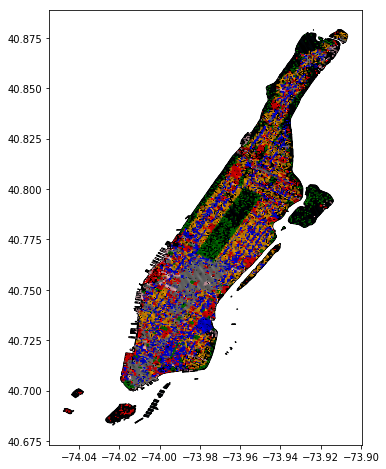

In [5]:
colors_per_class = {'Other': 'red', 'OpenSpace': 'green', 'Residential': 'orange',
                    'Commercial': 'gray', 'Transportation': 'pink', 'Mixed': 'blue'}

ax = gdf.plot(edgecolor='black', figsize = (8, 8))
for key, value in colors_per_class.items():
    plot_class = key
    df2 = gpd.GeoSeries(gdf.geometry[class_cells[plot_class]]);
    df2.plot(ax=ax, color=value);

In [6]:
# key = cell_id, value = list of pois -> {name, categories, lat, lon}
cells_dict = {}

# list of dictionaries {cell_id, name, categories, geometry}
pois_list = []

# for each poi inside pois list (from pois_50)
for poi in pois:
    # get cell_id information
    cell_id = int(poi[-1])
    
    # get the categories
    categories = poi[3].replace(' ', '_').split(':')
    
    # name of the poi
    name = poi[0]
    
    # location
    lat, lon = (float(poi[7]), float(poi[8]))
    
    # put poi inside structures
    if cell_id not in cells_dict:
        cells_dict[cell_id] = []
        
    if lon == 0 or lat == 0: continue
        
    if categories and len(categories) > 0 and categories[0] != '':
        cells_dict[cell_id].append({'name': name, 'categories': categories, 'lat': lat, 'lon': lon})
        poi_geometry = Point(lon, lat)
        pois_list.append({'cell_id': cell_id, 'name': name, 'categories': categories, 'geometry': poi_geometry})

# Create the dataframe
cell_pois_df = gpd.GeoDataFrame(pois_list)
cell_pois_df.head()

,categories,cell_id,geometry,name
0,"[Shop_&_Service, Souvenir_Shop]",10,POINT (-74.0462100506 40.6896279893),Statue of Liberty Gift Shop
1,"[Outdoors_&_Recreation, Park]",11,POINT (-74.046436 40.689881),Liberty Island Food Court
2,"[Professional_&_Other_Places, Government_Build...",11,POINT (-74.046317 40.68979),National Parks Services
3,"[Professional_&_Other_Places, Government_Build...",11,POINT (-74.046317 40.68979),National Parks Services
4,"[Food, American_Restaurant]",11,POINT (-74.0462694295 40.6898569793),Statue of Liberty Crown Cafe


## TEST with cell number
1. Select the cell and plot (red)

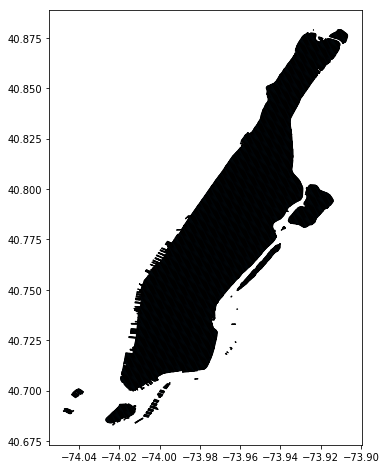

In [7]:
ax = gdf.plot(edgecolor='black', figsize = (8, 8))
gdf[gdf.cell_id == 4].plot(ax=ax, color='red');

2. Plot POIs (and centroid) of the cell

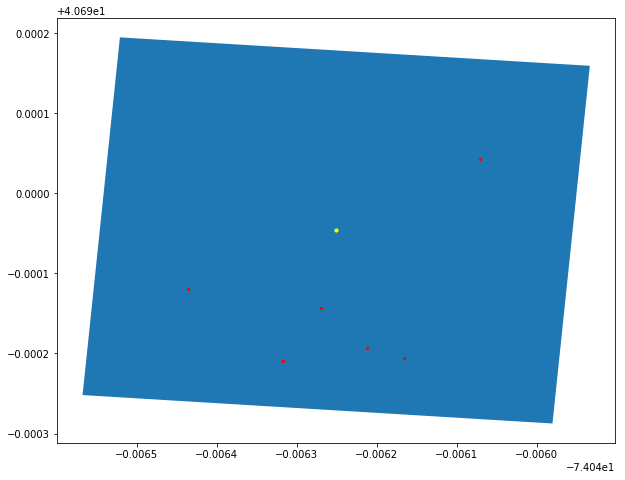

In [8]:
# NOTE: merged = gdf.merge(cell_pois_df, on='cell_id')
cell_11 = gdf[gdf.cell_id ==11]
cell_11_pois = cell_pois_df[cell_pois_df.cell_id ==11]

# plot cell
ax = cell_11.plot(figsize=(10, 10));

# plot pois (red)
cell_11_pois.plot(ax=ax, color='red', markersize=4)

# plot centroid (yellow)
centroid = gdf[gdf.cell_id ==11].geometry.centroid
centroid.plot(ax=ax, color='yellow', markersize=10)

### Definition of functions to build the sentence starting from POIs categories

In [9]:
def euclidian_distance(p1, p2):
    """
    Returns euclidian distance between p1 and p2
    p1 and p2 are shapely.Point object
    """
    return p1.distance(p2)

def get_nearest_point(start, list_points):
    """
    Returns the point inside list_points which is the nearest to *start*
    """
    min_point = list_points[0]
    min_dist = euclidian_distance(start, min_point)
    for p in list_points[1:]:
        dist = euclidian_distance(start, p)
        if dist < min_dist:
            min_dist = dist
            min_point = p
    return min_point

def get_start_point(polygon, list_points):
    """
    Returns the nearest point to the
    centroid of the polygon
    """
    return get_nearest_point(polygon.centroid, list_points)

def sort_cell_points(cell, list_points):
    """
    Input: - cell -> row of dataframe
           - list_points -> list of pois (shapely.Point) inside the cell.
    
    Output: - sorted_list -> ordered list of pois (get always the nearest point starting from centroid)
            - ordered_indexes -> indexes of the original list after reorder
    """
    initial_list = copy.deepcopy(list_points)
    ordered_indexes = []
    polygon = list(cell.geometry)[0]
    
    # get the start point
    # get the point nearest to centroid of the polygon
    start_point = get_start_point(polygon, list_points)
    sorted_list = [start_point]
    
    # remove the start point from the list
    index_to_remove = list_points.index(start_point) # get the index of the next point
    ordered_indexes.append(initial_list.index(start_point))
    del list_points[index_to_remove] # remove from the "to process" list
    
    next_point = start_point
    while len(list_points) > 0:
        next_point = get_nearest_point(next_point, list_points)
        sorted_list.append(next_point)
        to_remove = list_points.index(next_point)
        ordered_indexes.append(initial_list.index(next_point))
        del list_points[to_remove]
    
    return sorted_list, ordered_indexes

#### Test of the sort algorithm for the cell

In [10]:
# get all the geometries (points) which identify the POIs
pois_list = list(cell_11_pois.geometry)

# get all the categories for each of the POIS above
categories_list = list(cell_11_pois.categories)

# call the method sort_cell_points to sort the pois_list
sorted_list_pois, ordered_indexes = sort_cell_points(cell_11, pois_list)

# print the geometry of each sorted element (poi)
sorted_list_coords = [x.coords[0] for x in sorted_list_pois]
print(sorted_list_coords)

[(-74.0462694295, 40.6898569793), (-74.0462120571, 40.6898071889), (-74.0461661591, 40.6897940884), (-74.046317, 40.68979), (-74.046317, 40.68979), (-74.046436, 40.689881), (-74.0460705757, 40.6900428814)]


#### Plot of the line which connect the pois

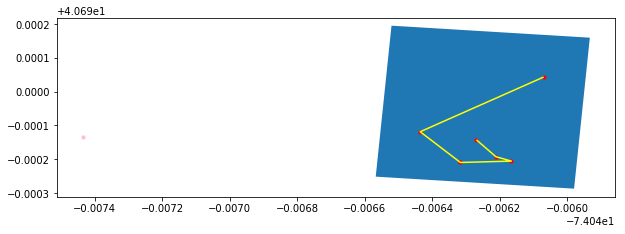

In [11]:
from shapely.geometry import LineString
line = LineString(sorted_list_coords)
line = gpd.GeoSeries({'geometry': line})

# plot cell
ax = cell_11.plot(figsize=(10, 10));

# plot pois (red)
cell_11_pois.plot(ax=ax, color='red', markersize=10)

# plot centroid (yellow)
centroid = gdf[gdf.cell_id == 1].geometry.centroid
centroid.plot(ax=ax, color='pink', markersize=10)
line.plot(ax=ax, color='yellow', markersize=5)

In [12]:
# extract the list of ordered categories
print("ordered categories inside the cell:")
ordered_categories = [categories_list[x] for x in ordered_indexes]
print(ordered_categories)

# print only the first class category
print("\nfirst class categories:")
first_class_categories = [x[0] for x in ordered_categories]
print(first_class_categories)

ordered categories inside the cell:
[['Food', 'American_Restaurant'], ['Travel_&_Transport', 'Pier'], ['Outdoors_&_Recreation', 'Island'], ['Professional_&_Other_Places', 'Government_Building', 'Monument_/_Landmark'], ['Professional_&_Other_Places', 'Government_Building', 'Monument_/_Landmark'], ['Outdoors_&_Recreation', 'Park'], ['Shop_&_Service', 'Gift_Shop']]

first class categories:
['Food', 'Travel_&_Transport', 'Outdoors_&_Recreation', 'Professional_&_Other_Places', 'Professional_&_Other_Places', 'Outdoors_&_Recreation', 'Shop_&_Service']


# BUILD sentence for each of cell (of the training)

In [13]:
# get the list of cell_id in training dataset
# datatype = 0 -> means training set
# datatype = 1 -> test
training_cell_ids = list(cells_df.loc[cells_df["data_type"] == 0].cell_id)
print("number of training cells", len(training_cell_ids))
max_cell_id = max(training_cell_ids)

# output lists
first_class_sentences = [] # sentences composed of the first categories in a cell
second_class_sentences = [] # ...
third_class_sentences = [] # ...
detailed_class_sentences = []
predominant_classes = []

# for each cell_id
for i in tqdm.tqdm(range(max_cell_id)):
    
    # skip index if is not in list of training cells
    if i not in training_cell_ids:
        continue
        
    # get the current cell    
    current_cell = gdf[gdf.cell_id == i]
    current_cell_pois = cell_pois_df[cell_pois_df.cell_id == i]
    
    if current_cell_pois.empty:
        continue
    
    # if here: current_cell is not empty
    pois_list = list(current_cell_pois.geometry)
    categories_list = list(current_cell_pois.categories)
    
    sorted_list_pois, ordered_indexes = sort_cell_points(current_cell, pois_list)
    sorted_list_coords = [x.coords[0] for x in sorted_list_pois]
    
    # get the predominant class of the cell
    predominat_class = list(cells_df.loc[cells_df["cell_id"] == i].predominant_class)[0]
    
    ordered_categories = [categories_list[x] for x in ordered_indexes]
    detailed_class_sentences.append(' '.join([x[-1] for x in ordered_categories]))
    first_class_sentences.append(' '.join([x[0] for x in ordered_categories]))
    predominant_classes.append(predominat_class)

  1%|▏         | 324/25167 [00:00<00:07, 3193.26it/s]

number of training cells 11641


100%|██████████| 25167/25167 [00:29<00:00, 844.53it/s]


# BUILD sentence for each of cell (of the test)

In [14]:
# get the list of cell_id in training dataset
# datatype = 0 -> means training set
# datatype = 1 -> test
test_cell_ids = list(cells_df.loc[cells_df["data_type"] == 1].cell_id)
print("number of test cells", len(test_cell_ids))
max_cell_id = max(test_cell_ids)

# output lists
test_first_class_sentences = [] # sentences composed of the first categories in a cell
test_second_class_sentences = [] # ...
test_third_class_sentences = [] # ...
test_detailed_class_sentences = [] # ...
test_predominant_classes = []

# for each cell_id
for i in tqdm.tqdm(range(max_cell_id)):
    
    # skip index if is not in list of training cells
    if i not in test_cell_ids:
        continue
        
    # get the current cell    
    current_cell = gdf[gdf.cell_id == i]
    current_cell_pois = cell_pois_df[cell_pois_df.cell_id == i]
    
    if current_cell_pois.empty:
        continue
    
    # if here: current_cell is not empty
    pois_list = list(current_cell_pois.geometry)
    categories_list = list(current_cell_pois.categories)
    
    sorted_list_pois, ordered_indexes = sort_cell_points(current_cell, pois_list)
    sorted_list_coords = [x.coords[0] for x in sorted_list_pois]
    
    # get the predominant class of the cell
    predominat_class = list(cells_df.loc[cells_df["cell_id"] == i].predominant_class)[0]
    
    ordered_categories = [categories_list[x] for x in ordered_indexes]
    test_detailed_class_sentences.append(' '.join([x[-1] for x in ordered_categories]))
    test_first_class_sentences.append(' '.join([x[0] for x in ordered_categories]))
    test_predominant_classes.append(predominat_class)

  2%|▏         | 460/25162 [00:00<00:05, 4482.15it/s]

number of test cells 4491


100%|██████████| 25162/25162 [00:11<00:00, 2097.65it/s]


In [15]:
import pickle

def save_list(filename, data):
    with open('./data/' + filename + '.pkl', 'wb') as f:
        pickle.dump(data, f)
        
def write_sentences_on_file(filename, main_sentences, main_predominant_classes):
    training_set_tuples = list(zip(main_sentences,
                                   main_predominant_classes))
    save_list(filename, training_set_tuples)
    print('wrote on', filename)
    
# mdetail
write_sentences_on_file('mdetail_training_set_50', detailed_class_sentences, predominant_classes)
write_sentences_on_file('mdetail_test_set_50', test_detailed_class_sentences, test_predominant_classes)

# first category
write_sentences_on_file('first_training_set_50', first_class_sentences, predominant_classes)
write_sentences_on_file('first_test_set_50', test_first_class_sentences, test_predominant_classes)

wrote on mdetail_training_set_50
wrote on mdetail_test_set_50
wrote on first_training_set_50
wrote on first_test_set_50
